# FREE FALL PREDICTION USING NEURAL NETWORK

## Firsts steps

### Loading the Python libraries

In this section, we import a comprehensive set of Python libraries that are essential for data analysis, machine learning, and scientific computing. Each library serves a specific purpose and collectively they provide a robust toolkit for developing, training, evaluating, and visualizing machine learning models. Specially:

* math: Provides access to mathematical functions and constants for performing basic arithmetic and more advanced mathematical operations.
* numpy (np): A fundamental package for scientific computing with Python. It offers powerful N-dimensional array objects and useful linear algebra, Fourier transform, and random number capabilities.
* pandas (pd): A powerful data manipulation and analysis library that provides data structures like DataFrames, which are essential for handling and analyzing structured data.
* tensorflow (tf) and keras: TensorFlow is an open-source machine learning framework used for building and training neural networks. Keras, integrated with TensorFlow, is a high-level API that simplifies the construction of deep learning models.
* sklearn (sk): Scikit-learn is a comprehensive library for machine learning in Python. It includes tools for model selection, preprocessing, and various machine learning algorithms.


In [ ]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error
from tensorflow import keras
from keras.callbacks import EarlyStopping

### Experimental data

The free fall data set captures experimental measurements of objects in free fall from varying heights. This data set consists of three primary variables: height, time, and dt. Each variable is represented as a numpy array with high precision (dtype=np.float64).

* Height (exp_height): This array contains the heights (in meters) from which objects were dropped. The heights range from 0.10 meters to 1.40 meters, providing a diverse set of measurements for analysis.

* Time (exp_time): This array records the time (in seconds) it takes for the objects to fall from the specified heights. These measurements are crucial for determining the relationship between height and time in free fall motion.

* Delta Time (exp_dt): This array represents the uncertainties or variations (in seconds) associated with the time measurements. These values are important for understanding the precision and reliability of the experimental data.

In [ ]:
exp_height = np.array([0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1.00, 1.10, 1.20, 1.30, 1.40], dtype=np.float64)
exp_time = np.array([0.16, 0.21, 0.26, 0.30, 0.33, 0.36, 0.39, 0.42, 0.44, 0.46, 0.48, 0.50, 0.52, 0.55], dtype=np.float64)
exp_dt = np.array([0.01, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.01, 0.02, 0.02, 0.01, 0.02, 0.02], dtype=np.float64)

data = pd.DataFrame({'height': exp_height, 'time': exp_time, 'dt': exp_dt})
data.head()

g_exp = 2*data["height"]/data["time"]**2

### Python functions to Data Generation and Gravitational Acceleration Calculation

This section introduces two key functions that are pivotal for generating augmented data based on empirical measurements and calculating gravitational acceleration considering latitude and height.

#### Data Generation

The _generate_data function is designed to create additional data points by incorporating random variations around the true experimental values. This is particularly useful for augmenting the dataset, allowing for a more robust analysis. Here's a breakdown of its functionality:

1. Input Data: The function takes the original data (data) and a parameter n, which dictates the number of new data points to generate for each original measurement.
2. True Experimental Values: The function first includes the actual experimental values in the height and time lists.
3. Data Augmentation: For each experimental measurement, the function generates n new height and time values by adding normally distributed random errors (err_h and err_t), simulating measurement variations.
4. Output: The function returns two numpy arrays containing the augmented heights and times.

In [ ]:
def _generate_data(data, n):

    height = []; time = [];

    ## It is wise to pick the true experimental values first
    height.extend(data["height"].tolist()); time.extend(data["time"].tolist());

    ## Generating the data based on the empirical set
    if n != 0:
        for i in range(np.shape(data)[0]):
            h = data["height"][i]; dh = 0.01;
            t = data["time"][i]; dt = data["dt"][i];
            err_h = np.random.normal(scale=dh, size=n)
            err_t = np.random.normal(scale=dt, size=n)
            err_t2 = np.random.normal(scale=dt**2, size=n)

            new_height = h + err_h + err_t2
            new_time = t + err_t

            height.extend(new_height.tolist())
            time.extend(new_time.tolist())

    return np.array(height), np.array(time)



In [ ]:
def _generate_tinydata(data, n):

    height = []; time = [];

    ## It is wise to pick the true experimental values first
    height.extend(data["height"].tolist()); time.extend(data["time"].tolist());
    df = len(height)-1

    ## Generating the data based on the empirical set
    if n != 0:
        for i in range(np.shape(data)[0]):
            h = data["height"][i]; dh = 0.01;
            t = data["time"][i]; dt = data["dt"][i];
            err_h = np.random.standard_t(df=df, size=n) * dh
            err_t = np.random.standard_t(df=df, size=n) * dt
            err_t2 = np.random.standard_t(df=df, size=n) * dt**2

            new_height = h + err_h + err_t2
            new_time = t + err_t

            height.extend(new_height.tolist())
            time.extend(new_time.tolist())

    return np.array(height), np.array(time)

#### Gravitational Acceleration Calculation

The calculate_gravitational_acceleration function computes the gravitational acceleration at a specific latitude and height above the Earth's surface. This calculation is essential for understanding how gravity varies with location and elevation. Here's how it works:

1. Constants: The function uses fundamental constants like the gravitational constant (G), the mass of the Earth (M), and the mean radius of the Earth (R).
2. Standard Gravitational Acceleration: It starts with the standard gravitational acceleration at sea level at the equator (g0).
3. Latitude Adjustment: The function adjusts for latitude using the formula involving coefficients beta and gamma, which account for the Earth's shape and rotation.
4. Height Adjustment: Finally, it adjusts for height above sea level, considering the change in gravitational acceleration with altitude.

In [ ]:
def calculate_gravitational_acceleration(latitude, height):
    # Constants
    G = 6.67430e-11  # Gravitational constant (m^3 kg^-1 s^-2)
    M = 5.972e24     # Mass of the Earth (kg)
    R = 6.371e6      # Mean radius of the Earth (m)

    # Standard gravitational acceleration at sea level at the equator
    g0 = 9.780

    beta = 0.0053024
    gamma = 0.0000058

    # Calculate the gravitational acceleration considering latitude
    latitude_rad = math.radians(latitude)
    g_latitude = g0 * (1 + beta * math.sin(latitude_rad)**2 - gamma * math.sin(2 * latitude_rad)**2)

    # Calculate the gravitational acceleration at the given height
    g_height = g_latitude * (1 - (2 * height / R))

    return g_height

## CASE 1 - Modelling the observable physical phenomena

We want to model the experimental data. Since there are few data points, the data was augmented using the experimental error as a reference.

We use the function _generate_tinydata(data, N=9) to get new data points 6 times bigger (14x10 = 140 points). We split the data as:

- 112 training points (80%)
- 14 validation points (10%)
- 14 testing points (10%)

In [ ]:
N = 9

height, time = _generate_tinydata(data,N)

y = height.reshape(-1,1)
x = time.reshape(-1,1)

# Data splitting
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.2, random_state=42)
x_valid, x_test, y_valid, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

y_test = y_test.reshape(-1,1)
x_test = x_test.reshape(-1,1)
x_train = x_train.reshape(-1,1)
y_train = y_train.reshape(-1,1)
x_valid = x_valid.reshape(-1,1)
y_valid = y_valid.reshape(-1,1)

print(f"train, valid, and test samples are {x_train.shape[0]}, {x_valid.shape[0]}, and {x_test.shape[0]} respectively...")

train, valid, and test samples are 112, 14, and 14 respectively...


## CASE 2: Like the theoreticals do...

We want to do like the theoreticals do: pick a simulation based on theory and compared with the real world! We can apply Newton's Laws to get the amount of data needed for this.

We use the function to generate the artificial data with random noise. Almost 128 points:

- 102 training points (80%)
- 26 validation points (20%)

However, we want to compare the quality of the model with the world. So we use these data as a reference to verify the quality of the model.



In [ ]:
# Experiments on IFGW ---- (The g is something between 9.7845 - 9.7877 m/s)
latitude_ifgw = 22.8170778
height_ifgw = 601
g_calc = calculate_gravitational_acceleration(latitude_ifgw, height_ifgw)

# Artificial dataset
n = 128
sim_time = np.linspace(0., 0.66, n, dtype=np.float64)
sim_height = 0.5 * g_calc * sim_time**2 + np.random.normal(0, 0.1, len(sim_time))

y = sim_height
x = sim_time


# Data splitting
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, random_state=42)

x_train = x_train.reshape(-1,1)
y_train = y_train.reshape(-1,1)
x_valid = x_valid.reshape(-1,1)
y_valid = y_valid.reshape(-1,1)

## This data is empirical (n == 0) or empirical derived (n != 0)
y_test, x_test = _generate_data(data,0)
y_test = y_test.reshape(-1,1)
x_test = x_test.reshape(-1,1)

print(f"train, valid, and test samples are {x_train.shape[0]}, {x_valid.shape[0]}, and {x_test.shape[0]} respectively...")

train, valid, and test samples are 102, 26, and 14 respectively...


## MODELLING

We can descrive the free fall phenomena by different perspectives:
- Linear: Better at lower heights...
- Quadratic: Can be very important at higher height levels!
- NN: Why not?

In [ ]:
## Dummy Fitting Line - just to plot a smooth line on plots
dummy_fitting_line = np.linspace(x.min(), x.max(), 666, dtype=np.float64).reshape(-1,1)


## LINEAR MODEL

This is the traditional way to model the free fall kinetic problem. It is less prone to fit noise and error, besides the high degree of freedom to estimate the parameters.

The gravitational acceleration is 2*angular_coefficient!

In [ ]:
linear_model = LinearRegression()
linear_model.fit(x_train**2, y_train)

y_pred = linear_model.predict(x_test**2)
g_linear = 2*linear_model.coef_[0][0]

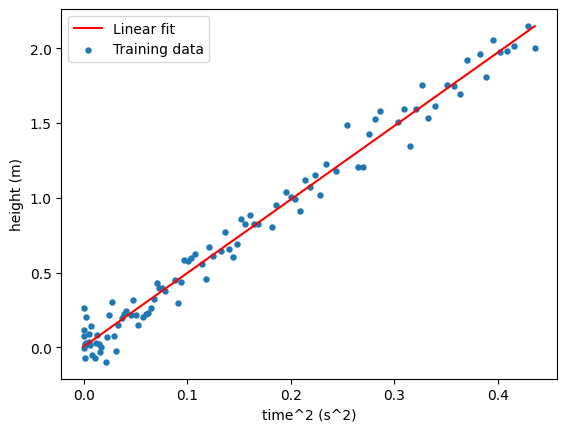

<Figure size 640x480 with 0 Axes>

In [246]:
## Plotting the data
plt.plot(dummy_fitting_line**2, linear_model.predict(dummy_fitting_line**2), label="Linear fit", color="red")
plt.scatter(x_train**2, y_train, label="Training data", s=13)
#plt.scatter(x_test**2, y_test, label="Test data")

plt.xlabel("time^2 (s^2)")
plt.ylabel("height (m)")
plt.legend()
plt.show()
plt.savefig('Linear_fit.png')

In [ ]:

print("LINEAR REGRESSION")
print(f"Coefficients: the linear is {linear_model.coef_[0][0]:.4f} and the intercetp is {linear_model.intercept_[0]:.4f}!")
print(f"R-squared (R²) value is {r2_score(y_test, y_pred):.4f}.")
print(f"Root mean square error of prediction (RMSEP) is {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}.")
print(f"Free fall acceleration is: {g_linear:.4f} m/s^2")
print(f"The relative error in this measure is {100*abs(g_linear-g_calc)/g_calc:.4f}%.")

LINEAR REGRESSION
Coefficients: the linear is 4.9143 and the intercetp is 0.0062!
R-squared (R²) value is 0.9845.
Root mean square error of prediction (RMSEP) is 0.0501.
Free fall acceleration is: 9.8286 m/s^2
The relative error in this measure is 0.4363%.


## QUADRATIC MODEL

This is the physical way to describe the free fall kinetic problem using Newton's laws. But we will have more parameters and we are able to fit wrongly the experimental data error.

The gravitational acceleration is 2*quadratic_term_coefficient!

In [ ]:
poly_features = PolynomialFeatures(degree=2)
x_poly = poly_features.fit_transform(x_train)
quadratic_model = LinearRegression()
quadratic_model.fit(x_poly, y_train)

y_pred = quadratic_model.predict(poly_features.transform(x_test))
g_quadratic = 2*quadratic_model.coef_[0][2]

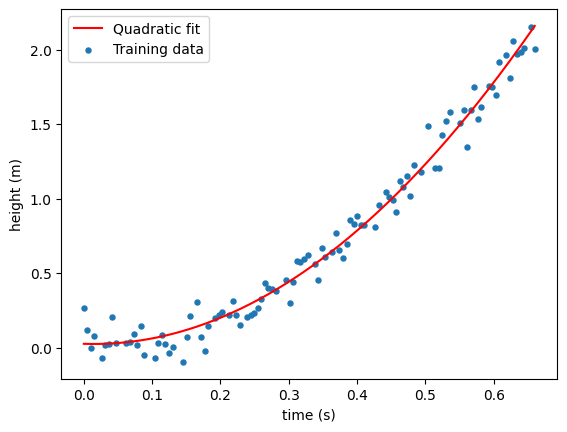

In [ ]:
plt.plot(dummy_fitting_line, quadratic_model.predict(poly_features.transform(dummy_fitting_line)), label="Quadratic fit", color="red")
plt.scatter(x_train, y_train, label="Training data", s=13)
#plt.scatter(x_test, y_test, label="Test data")
plt.xlabel("time (s)")
plt.ylabel("height (m)")
plt.legend()
plt.show()

In [ ]:
print("QUADRATIC REGRESSION")
print(f"Coefficients: the quadratic, linear and intercept terms are {quadratic_model.coef_[0][2]:.4f}, {quadratic_model.coef_[0][1]:.4f}, and {quadratic_model.intercept_[0]:.4f} respectively!")
print(f"R-squared (R²) value is {r2_score(y_test, y_pred):.4f}.")
print(f"Root mean square error of prediction (RMSEP) is {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}.")
print(f"Free fall acceleration is: {g_quadratic:.4f} m/s^2")
print(f"The relative error in this measure is {100*abs(g_quadratic-g_calc)/g_calc:.4f}%.")

QUADRATIC REGRESSION
Coefficients: the quadratic, linear and intercept terms are 5.1269, -0.1505, and 0.0249 respectively!
R-squared (R²) value is 0.9872.
Root mean square error of prediction (RMSEP) is 0.0456.
Free fall acceleration is: 10.2539 m/s^2
The relative error in this measure is 4.7819%.


## NEURAL NETWORK

The McCulloch-Pitts neuron (1943) is a device that has **x** inputs with a **w** synaptic weight associated to each them. It can be excitatory (wi > 0) or inhibitory (wi < 0). The device also has a binary output, representing one of two possible states (0/1 or -1/1). To determine the neuron's output, synaptic integration is performed, the weighted sum: y = **w'x**

If the sum y is greater than or equal to a threshold (T), the neuron becomes active and the output is a pulse (z = 1). Otherwise, it remains inactive and the output is a non-pulse (z = -1), in other words: z = f(y-T).

The function f is called the activation function, usually approximated by a step function f(x) = h(x) or a sign function f(x) = sgn(x). Here, the output was given by the rectified linear unit, f(x) = max(0,x). This function can be used to describe nonlinear problems, such this case.

The threshold T can be incorporated on the weighted sum, w0 = T. Henceforth, we can simplify the notation from 1 ... N to 0 .. N neurons on y = **w'x**. So the great idea is to optimize the weight and threshold of the neural network weights. In this case, the aim was to reduce the mean square error using a gradient descent technique (adaptative Moment Estimation -- Adam). It is an overkill for our problem, but it suits well.


#### **Architecture**

The network architecture is based on the feedforward neural network fully connected (also known as "dense"). All the previous neurons are connected to the next one layer.

**Input Layer (1 neuron) -> Hidden Layer 1 (64 neurons) -> Hidden Layer 2 (64 neurons) -> Output Layer (1 neuron)**

*Input Layer + First Hidden Layer*

This is the entry and it is able to tranfer the feed data shape to the neurons! The input layer send the data to the first hidden layer that will process the data among 64 neurons using the Rectified Linear Unit (ReLU) as the activation function.

*Second Hidden Layer*

It will process the first hidden layer data and send it to the output layer. Again, it works with 64 neurons and deals with the ReLU activation function.

*Output Layer*

This is the output layer with only 1 neuron, cause the output is a scalar (the predicted height).


#### **Fitting Parameters**

For each interaction, the model will be feed with 16 training samples. This is simillar to the k-fold CV, just like the epoch concept. A low value of batch_size avoid the overfitting and a high amount of epochs ensure that the model will have more ability to fit the data.

We used a callback to monitor the validation loss along the model fitting. In this scenario, if the validation doesn't improve on the next 50 epochs, then the train will be finished.


In [ ]:
input_shape = (x_train.shape[1],)

nn_model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=input_shape),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1)
])

## compilation
nn_model.compile(optimizer='adam', loss='mean_squared_error')

# training the model
nn_model.fit(x_train, y_train, epochs=500, batch_size=16, validation_data=(x_valid, y_valid),
             callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)])

## Evaluate the model on the test set
nn_model.evaluate(x_test, y_test)

## Make predictions on new data
## Replace 'new_data' with the actual new data you want to predict on
y_pred = nn_model.predict(x_test)

Epoch 1/500
7/7 [==============================] - 1s 27ms/step - loss: 0.9493 - val_loss: 0.7506
Epoch 2/500
7/7 [==============================] - 0s 7ms/step - loss: 0.7044 - val_loss: 0.5601
Epoch 3/500
7/7 [==============================] - 0s 9ms/step - loss: 0.5209 - val_loss: 0.4157
Epoch 4/500
7/7 [==============================] - 0s 9ms/step - loss: 0.3762 - val_loss: 0.3112
Epoch 5/500
7/7 [==============================] - 0s 9ms/step - loss: 0.2790 - val_loss: 0.2372
Epoch 6/500
7/7 [==============================] - 0s 10ms/step - loss: 0.2076 - val_loss: 0.1957
Epoch 7/500
7/7 [==============================] - 0s 8ms/step - loss: 0.1676 - val_loss: 0.1787
Epoch 8/500
7/7 [==============================] - 0s 8ms/step - loss: 0.1513 - val_loss: 0.1715
Epoch 9/500
7/7 [==============================] - 0s 8ms/step - loss: 0.1435 - val_loss: 0.1606
Epoch 10/500
7/7 [==============================] - 0s 6ms/step - loss: 0.1325 - val_loss: 0.1469
Epoch 11/500
7/7 [=========

21/21 [==============================] - 0s 1ms/step


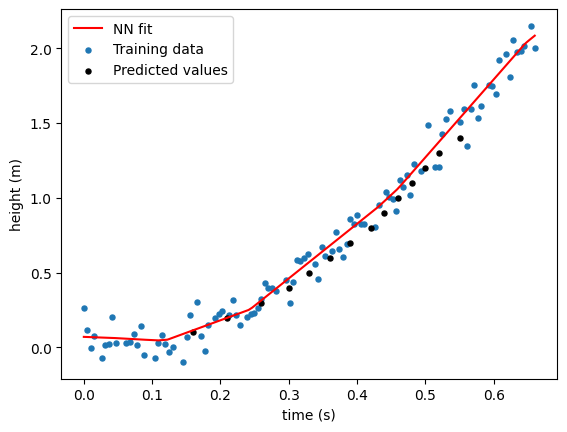

In [ ]:
plt.plot(dummy_fitting_line, nn_model.predict(dummy_fitting_line), label="NN fit", color="red")
plt.scatter(x_train, y_train, label="Training data", s=13)
plt.scatter(x_test, y_test, label="Predicted values", s=13, color="black")
plt.xlabel("time (s)")
plt.ylabel("height (m)")
plt.legend()
plt.show()

In [ ]:
## Calculate the g acceleration
g_temp = 2*y_pred/x_test**2
g_nn = np.mean(g_temp)

g_temp1 = 2*linear_model.predict(x_test**2)/x_test**2
g_temp2 = 2*quadratic_model.predict(poly_features.transform(x_test))/x_test**2

print(f"The error associated to determine the gravitational acceleration is:")
print(f" - P1 : {np.sqrt(mean_squared_error(g_exp, g_temp1)):.4f} m/s^2")
print(f" - P2 : {np.sqrt(mean_squared_error(g_exp, g_temp2)):.4f} m/s^2")
print(f" - NN : {np.sqrt(mean_squared_error(g_exp, g_temp)):.4f} m/s^2")

The error associated to determine the gravitational acceleration is:
 - P1 : 0.9706 m/s^2
 - P2 : 0.9039 m/s^2
 - NN : 0.9240 m/s^2


In [ ]:
print("NEURAL NETWORK")
print(f"R-squared (R²) value is {r2_score(y_test, y_pred):.4f}.")
print(f"Root mean square error of prediction (RMSEP) is {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}.")
print(f"Free fall acceleration is: {g_nn:.4f} m/s^2")
print(f"The relative error in this measure is {100*abs(g_nn-g_calc)/g_calc:.4f}%.")

NEURAL NETWORK
R-squared (R²) value is 0.9667.
Root mean square error of prediction (RMSEP) is 0.0736.
Free fall acceleration is: 9.9862 m/s^2
The relative error in this measure is 2.0467%.
